In [3]:
from bayes_opt import BayesianOptimization
import numpy as np
from plotutil import Figure
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn
%matplotlib inline

plt.rcParams['image.cmap'] = 'jet'

In [4]:
def posterior(bo, x):
    bo.gp.fit(bo.X, bo.Y)
    mu, sigma = bo.gp.predict(x, return_std=True)
    return mu, sigma
    

def plot_gp(bo, x, y=None, axes=None, high_light=False, y_lim=None):
    levels = (np.linspace(*y_lim, 20) if y_lim else 20, 20)

    if axes is None:
        fig = plt.figure(figsize=(6, 4.5))
        fig.suptitle('Gaussian Process and Utility Function After {} Steps'.format(len(bo.X)), fontdict={'size':30})

        gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
        axis = plt.subplot(gs[0])
        acq = plt.subplot(gs[1])
    else:
        axis_Q = axes[0]
        axis = axes[2]
        acq = axes[3]

    x_flat = np.array((x[0].reshape(-1), x[1].reshape(-1))).T
    mu, sigma = posterior(bo, x_flat)
    mu = mu.reshape(x[0].shape)
    if y is not None:
        axis.plot(x, y, linewidth=3, label='Target')
    
    axis.plot(*bo.X.T, 'D', markersize=8, label=u'Observations', color='r')
    if high_light:
        axis.plot(*bo.X[-1], 'D', markersize=8, label=u'Last observation', color='gold')
    cs = axis.contourf(*x, mu, levels[0])
    plt.colorbar(cs, ax=axis)
    
    axis_Q.plot(*x_flat[np.argmax(mu)], '*', markersize=15, label=u'Current optimum',
                markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)

    #axis.fill(np.concatenate([x, x[::-1]]), 
    #          np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
    #    alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    #axis.set_ylim(y_lim)
    axis.set_ylabel('S(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility = bo.util.utility(x_flat, bo.gp, 0)
    utility = utility.reshape(x[0].shape)
    acq.contourf(*x, utility, levels[1])
    acq.plot(*x_flat[np.argmax(utility)], '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
 
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis_Q.legend(loc='upper right')
    axis.legend(loc='upper right')#, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc='upper right')#, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

In [5]:
xy_range = ((0, 3), (0, 3))
grid = np.meshgrid(np.linspace(*xy_range[0], 21),
                   np.linspace(*xy_range[1], 21)) 
Q = np.logical_and(
      np.logical_and(grid[0] >= 1, grid[0] <= 2),
      np.logical_and(grid[1] >= 1, grid[1] <= 2)) 

#plt.pcolor(*grid, Q)

In [6]:
xy_range = ((0, 3), (0, 3))
grid = np.meshgrid(np.linspace(*xy_range[0], 21),
                   np.linspace(*xy_range[1], 21)) 
Q = np.random.random(grid[0].shape)

#plt.pcolor(*grid, Q)

In [7]:
def R(x_c, y_c, grid=grid):
    a = 1
    r = a**2 - ((grid[0]-x_c)**2 + (grid[1]-y_c)**2)
    r[r<0] = 0
    return r / 20


#plt.pcolor(*grid, R(1.5, 1.5))

In [28]:
def R(x_c, y_c, grid=grid):
    return np.exp(-np.abs(grid[0]-x_c)-np.abs(grid[1]-y_c))


#plt.pcolor(*grid, R(1.5, 1.5))

ValueError: not enough values to unpack (expected 2, got 0)

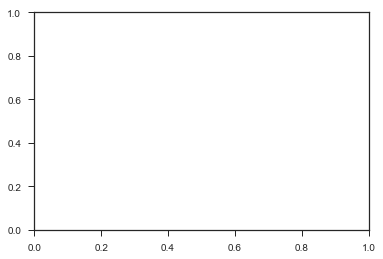

In [15]:
S_1 = lambda x, y: Q*R(x, y)


def S_sum(**kwargs):
    S_temp = []
    for i in range(int(len(kwargs)/2)):
        x = kwargs['x'+str(i)]
        y = kwargs['y'+str(i)]
        S_temp.append(S_1(x, y))

    S_sum = S_temp[0]
    for i in range(1, int(len(kwargs)/2)):
        S_sum = np.maximum(S_sum, S_temp[i])
    return 

def S(**kwargs):    
    return np.sum(S_sum(**kwargs).reshape(-1, 1)) / 5

plt.pcolor(*grid, S_sum(x0=1.5, y0=1.5))

In [35]:
def set_lim(axis, grid, p=0.1):
    x_lim = (np.min(grid[0].reshape(-1)), np.max(grid[0].reshape(-1)))
    y_lim = (np.min(grid[1].reshape(-1)), np.max(grid[1].reshape(-1)))
    
    def extend(x_a, x_b, p=p):
        return x_a - (x_b - x_a)*p, x_b + (x_b - x_a)*p
    
    axis.set_xlim(extend(*x_lim))
    axis.set_ylim(extend(*y_lim))


def plot_QS_gp(Q, S_temp, bo, grid, i, y_lim):
    levels = 20
    fig = Figure(2, 2, figsize=(16, 12))
    fig[0].contourf(*grid, Q, levels)
    if i > 0:
        x_last = bo.X[-1]
        fig[1].contourf(*grid, S_temp(*x_last), levels)
    fig[0].set_ylabel('Q(x)', fontdict={'size':20})
    fig[1].set_ylabel('Q(x)*R(x)', fontdict={'size':20})
    
    plot_gp(bo, grid, axes=fig, high_light=i>0, y_lim=y_lim)
    for axis in fig:
        set_lim(axis, grid)
    fig.close('radar/figs', f'bo_2d_quadratic_{i}')


def optimize(bo, init_points, n_iter, y_lim=(None, None)):
    bo.maximize(init_points=init_points, n_iter=0)
    plot_QS_gp(Q, S_1, bo, grid, 0, y_lim=y_lim)
    for i in range(n_iter):
        bo.maximize(n_iter=1)
        plot_QS_gp(Q, S_1, bo, grid, i+1, y_lim=y_lim)

In [37]:
S_lim = (0, 1)
bo = BayesianOptimization(S, {'x': xy_range[0], 'y': xy_range[1]})
optimize(bo, init_points=10, n_iter=10, y_lim=S_lim)

Initialization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 
    1 | 00m00s |    0.31473 |    0.5447 |    1.5688 | 
    2 | 00m00s |    0.32087 |    0.8886 |    2.4467 | 
    3 | 00m00s |    0.36824 |    2.4183 |    1.1402 | 
    4 | 00m00s |    0.36071 |    1.3720 |    0.6399 | 
    5 | 00m00s |    0.18234 |    2.3978 |    2.9992 | 
    6 | 00m00s |    0.24934 |    0.1928 |    1.7885 | 
    7 | 00m00s |    0.19164 |    0.0342 |    2.5042 | 
    8 | 00m00s |    0.30479 |    0.4816 |    2.3826 | 
    9 | 00m00s |    0.32706 |    1.7691 |    2.4216 | 
   10 | 00m00s |    0.34626 |    1.5096 |    2.0269 | 


Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 


Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 


   11 | 00m08s |    0.13028 |    3.0000 |    0.0000 | 


Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 


   12 | 00m11s |    0.11973 |    0.0000 | 

   0.0000 | 
Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 


   13 | 00m14s |    0.38090 |    1.7587 |    1.2109

 | 
Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 


   14 | 00m12s |    0.20353 |    3.0000

 |    1.7421 | 
Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 


   15 | 00m13s |    0.36789 |    2.0099 |    0.6673 | 


Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 


   16 | 00m12s |    0.37993 |    2.0921 |    1.5201 | 


Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 


   17 | 00m17s |    0.39286 |    2.0738 |    1.1125 | 


Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 


   18 | 00m15s |    0.35320 |    1.2289 |    1.2064 | 


Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 


   19 | 00m13s |    0.38516 |    1.8462 |    0.9388 | 


Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 


   20 | 00m17s |    0.39195 |    2.0821 |    1.2720 | 


In [9]:
bo = BayesianOptimization(S, {'x': xy_range[0], 'y': xy_range[1]})
bo.maximize(init_points=50, n_iter=10)

Initialization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 
    1 | 00m00s |    1.37094 |    2.9567 |    1.6181 | 
    2 | 00m00s |    2.07118 |    1.2369 |    2.4982 | 
    3 | 00m00s |    2.56312 |    0.7040 |    1.2546 | 
    4 | 00m00s |    1.56405 |    0.3374 |    1.9364 | 
    5 | 00m00s |    0.59847 |    0.2426 |    0.1978 | 
    6 | 00m00s |    3.73929 |    1.0371 |    1.5169 | 
    7 | 00m00s |    1.59489 |    2.6639 |    1.0845 | 
    8 | 00m00s |    0.98224 |    0.4952 |    0.4407 | 
    9 | 00m00s |    3.11303 |    1.3708 |    0.8668 | 
   10 | 00m00s |    1.92740 |    2.6260 |    1.4663 | 
   11 | 00m00s |    1.04675 |    2.9667 |    0.9661 | 
   12 | 00m00s |    2.01807 |    1.8296 |    2.4850 | 
   13 | 00m00s |    1.72310 |    1.7934 |    0.3360 | 
   14 | 00m00s |    4.19683 |    1.5854 |    1.1895 | 
   15 | 00m00s |    0.49994 |    0.0015 |    2.7410 | 
   16 | 00m00s |    2.71477 |    1.3897 |    2.2758

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |         x |         y | 


   51 | 00m15s |    4.55881 |    1.4928 |    1.5103 | 


KeyboardInterrupt: 